# Pytorch Computer Vision model for digit prediction

In [3]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from torchmetrics import Accuracy

import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from timeit import default_timer as timer

# Exercises require PyTorch > 1.10.0
print(torch.__version__)
# TODO: Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

1.13.1+cu117


'cuda'

Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [5]:
train_data = datasets.MNIST(
    root='MNIST',
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root='MNIST',
    train=False,
    download=True,
    transform=ToTensor(),
)

Failed to download (trying next):
<urlopen error [WinError 10061] Подключение не установлено, т.к. конечный компьютер отверг запрос на подключение>



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST\MNIST\raw\train-images-idx3-ubyte.gz to MNIST\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] Подключение не установлено, т.к. конечный компьютер отверг запрос на подключение>



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to MNIST\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] Подключение не установлено, т.к. конечный компьютер отверг запрос на подключение>



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] Подключение не установлено, т.к. конечный компьютер отверг запрос на подключение>



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST\MNIST\raw



In [6]:
len(train_data), len(test_data)

(60000, 10000)

## Data understanding

In [8]:
# classes of dataset

class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [9]:
# shape of samples

image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 5)

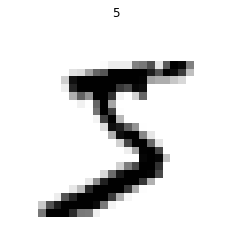

In [10]:
# show how it look

plt.imshow(image.squeeze(), cmap='binary')
plt.axis(False)
plt.title(label);

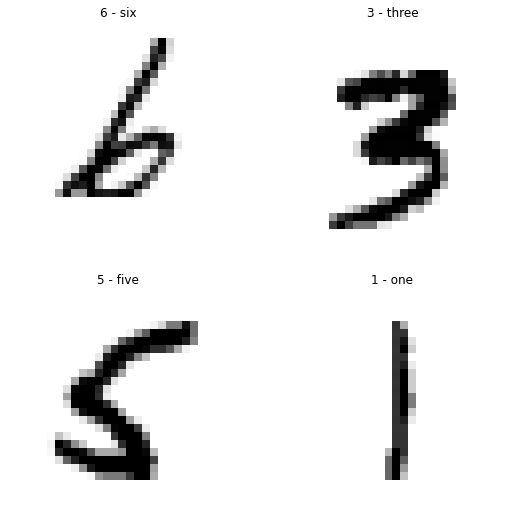

In [11]:
# Visualize 4 random images

fig = plt.figure(figsize=(9, 9))
rows, cols = 2, 2
for i in range(1, rows*cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='binary')
    plt.title(class_names[label])
    plt.axis(False);

## Turn datasets into dataloaders

In [12]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST
    Split: Train
    StandardTransform
Transform: ToTensor()

In [13]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2a4edf68310>,
 <torch.utils.data.dataloader.DataLoader at 0x2a495ad9a30>)

In [14]:
len(train_dataloader)

1875

## Make CNN VGG-like model with 2 convolutional blocks

In [15]:
class TinyVGG_2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        
        # Convolutional block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3, 
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Convolutional block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        
        # Classifier layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units * 7*7, #image size after conv and pool
                out_features=output_shape
            ),
        )
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.classifier(x)
        
        return x

In [21]:
numbers_model = TinyVGG_2(input_shape=1,
                          hidden_units=10,
                          output_shape=len(class_names)).to('cuda')

numbers_model

TinyVGG_2(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## Train model 

In [17]:
# timer function

def print_time(start, end, device):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [24]:
# Set loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=numbers_model.parameters(), lr=0.1)
accuracy_fn = Accuracy(task='multiclass', num_classes=len(class_names)).cuda()

In [25]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
    
    train_loss, train_acc = 0, 0
    model.train()
    
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(data_loader)
    train_acc = 100 * train_acc / len(data_loader)
    print(f"Train loss: {train_loss:.5f}  |  Train acc: {train_acc:.2f}%")

In [26]:
def test_step(model, data_loader, loss_fn, accuracy_fn, device):
    
    test_loss, test_acc = 0, 0
    model.eval()
    
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_pred = model(X_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y_test)
            
        test_loss /= len(data_loader)
        test_acc = 100 * test_acc / len(data_loader)
        
    print(f"Test loss: {test_loss:.5f}  |  Test acc: {test_acc:.2f}%")

In [27]:
# model on gpu

EPOCHC = 10


start_time = timer()

for epoch in tqdm(range(EPOCHC)):
    print(f"Epoch: {epoch}\n--------")
    train_step(
        model=numbers_model,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device='cuda'
    )
    
    test_step(
        model=numbers_model,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device='cuda'
    )

end_time = timer()
gpu_total_time = print_time(start_time, end_time, 'cuda')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 0.59884  |  Train acc: 78.87%
Test loss: 0.08160  |  Test acc: 97.39%
Epoch: 1
--------
Train loss: 0.09539  |  Train acc: 97.12%
Test loss: 0.06424  |  Test acc: 97.94%
Epoch: 2
--------
Train loss: 0.07451  |  Train acc: 97.69%
Test loss: 0.05832  |  Test acc: 98.05%
Epoch: 3
--------
Train loss: 0.06208  |  Train acc: 98.14%
Test loss: 0.06398  |  Test acc: 97.87%
Epoch: 4
--------
Train loss: 0.05641  |  Train acc: 98.33%
Test loss: 0.04399  |  Test acc: 98.53%
Epoch: 5
--------
Train loss: 0.05069  |  Train acc: 98.48%
Test loss: 0.04607  |  Test acc: 98.45%
Epoch: 6
--------
Train loss: 0.04767  |  Train acc: 98.51%
Test loss: 0.04709  |  Test acc: 98.43%
Epoch: 7
--------
Train loss: 0.04301  |  Train acc: 98.69%
Test loss: 0.04749  |  Test acc: 98.49%
Epoch: 8
--------
Train loss: 0.04187  |  Train acc: 98.68%
Test loss: 0.04474  |  Test acc: 98.59%
Epoch: 9
--------
Train loss: 0.03959  |  Train acc: 98.74%
Test loss: 0.03892  |  Test acc: 98.81%


## Make predictions

In [28]:
def make_predictions(model, data, device=device):
    
    pred_probs = []
    model.to(device)
    model.eval()
    
    with torch.inference_mode():
        for sample in data:
            
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logits = model(sample)
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
            
    return torch.stack(pred_probs)

In [29]:
import random

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
    
test_samples[0].shape, test_labels[0]

(torch.Size([1, 28, 28]), 8)

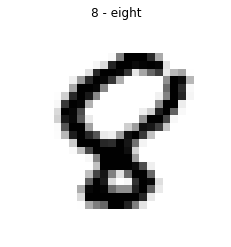

In [30]:
plt.imshow(test_samples[0].squeeze(), cmap='binary')
plt.title(class_names[test_labels[0]])
plt.axis(False);

In [31]:
pred_probs = make_predictions(model=numbers_model, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([8, 7, 5, 8, 0, 7, 3, 6, 0])

In [32]:
print(f"Preds: {pred_classes}")
print(f"True: {test_labels}")

Preds: tensor([8, 7, 5, 8, 0, 7, 3, 6, 0])
True: [8, 7, 5, 8, 0, 7, 3, 6, 0]


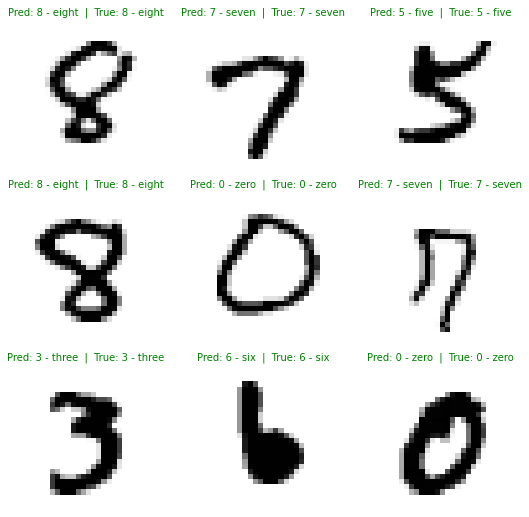

In [33]:
# plot preds

plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap='binary')
    pred_label = class_names[pred_classes[i]]
    true_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label}  |  True: {true_label}"
    
    if pred_label == true_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')
        
    plt.axis(False);

### Plot a confusion matrix comparing model's predictions to the truth labels

In [35]:
y_preds = []
numbers_model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)
        y_logits = numbers_model(X)
        y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())
        
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([7, 2, 1, 0, 4, 1, 8, 9, 5, 9])

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

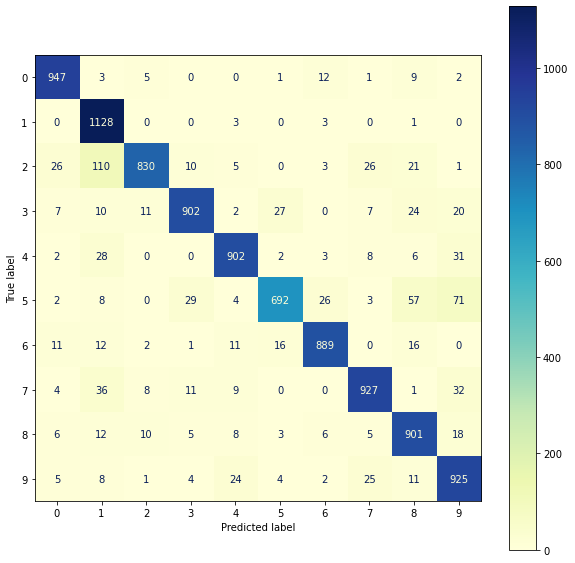

In [37]:
conf = confusion_matrix(test_data.targets, y_pred_tensor)
fig, ax = plt.subplots(figsize=(10,10))
conf_img = ConfusionMatrixDisplay(conf)
conf_img.plot(ax=ax, cmap='YlGnBu');

## Save model

In [ ]:
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = 'number_predictor.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [ ]:
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=numbers_model, f=MODEL_SAVE_PATH)